In [10]:
import os
import importlib.util
import math

import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import pickle

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import load_data, feature_names, load_data2
from data.hlf_preprocessing import HLFDataPreprocessor, load


In [11]:
#paths
result_path = '/home/oliverkn/pro/results/4_4/alad/test_if_result_works/'
#result_path = '/home/oliverkn/euler/results/hlf_set/alad/ultra_big_lat4/'
data_path = '/home/oliverkn/pro/data/hlf_set'
config_file = result_path + 'config.py'
weights_file = result_path + 'model-110000'

max_samples = 2_000_000

# loading config
spec = importlib.util.spec_from_file_location('config', config_file)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config, tf.Session())
ad.load(weights_file)


data shape:(741098, 21)
data shape:(699681, 21)
data shape:(556806, 21)
data shape:(553266, 21)


/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


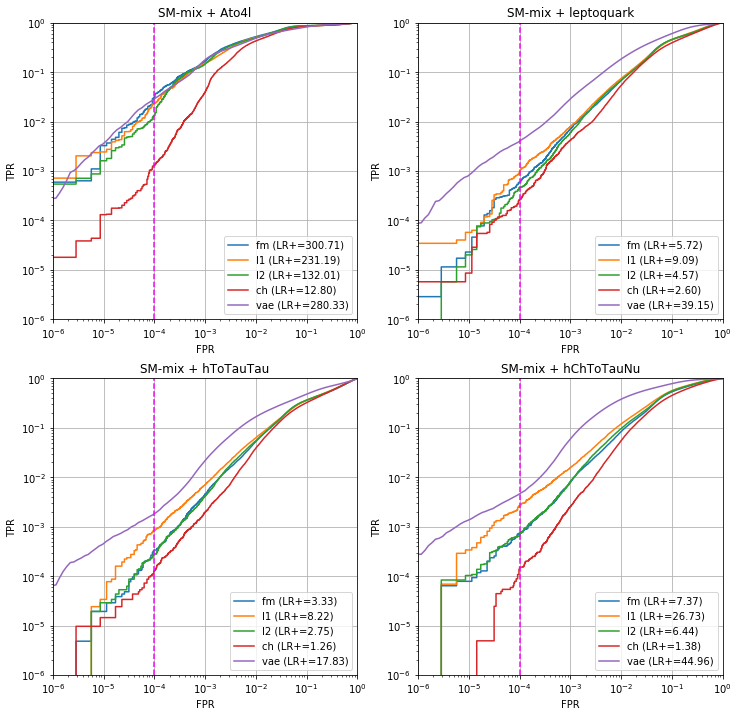

In [12]:
vae_roc = {}
vae_roc['Ato4l'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_Ato4l.pkl', 'rb'), encoding='latin1') 
vae_roc['leptoquark'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_leptoquark.pkl', 'rb'), encoding='latin1') 
vae_roc['hToTauTau'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_hToTauTau.pkl', 'rb'), encoding='latin1') 
vae_roc['hChToTauNu'] = pickle.load(open('vae_roc/VAE_all-in-one_v71_ROC1_dict_hChToTauNu.pkl', 'rb'), encoding='latin1') 

max_samples = 1_000_000
target_fpr = 1e-4
sm_list = ['Wlnu', 'qcd', 'Zll', 'ttbar']
sm_fraction = [0.592, 0.338, 0.067, 0.003]
bsm_list = ['Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']

fig, ax_arr = plt.subplots(2, 2, figsize=(12, 12))
for i, bsm in enumerate(bsm_list):
    x, y = load_data2(data_path, set='valid', type='custom', sm_list = sm_list, bsm_list=[bsm], sm_fraction=sm_fraction)
    # take subset
    if x.shape[0] > max_samples:
        x, y = x[:max_samples], y[:max_samples]
    x = preprocessor.transform(x)
    print('data shape:' + str(x.shape))
    
    ax = ax_arr[i//2, i%2]
    
    scores = ad.compute_all_scores(x)
    score_names = ['fm', 'l1', 'l2', 'ch']
    for score, name in zip(scores, score_names):
        fpr, tpr, _ = roc_curve(y, score, pos_label=1)
        #auroc = roc_auc_score(y, score)
        idx = np.argmax(fpr>target_fpr)
        lr_plus = tpr[idx] / fpr[idx]
        ax.loglog(fpr, tpr, label=name+' (LR+=%.2f)'%lr_plus)
    
    #plot vae reference
    fpr, tpr = vae_roc[bsm]['eff_SM'],vae_roc[bsm]['eff_BSM']
    idx = np.argmax(fpr>target_fpr)
    lr_plus = tpr[idx] / fpr[idx]
    ax.loglog(fpr, tpr, label='vae (LR+=%.2f)'%lr_plus)
    
    ax.axvline(target_fpr, ls='--', color='magenta')
    ax.set_title('SM-mix + ' + bsm)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.grid()
    ax.set(xlim=(1e-6, 1), ylim=(1e-6, 1))
    ax.legend()
    
plt.show()

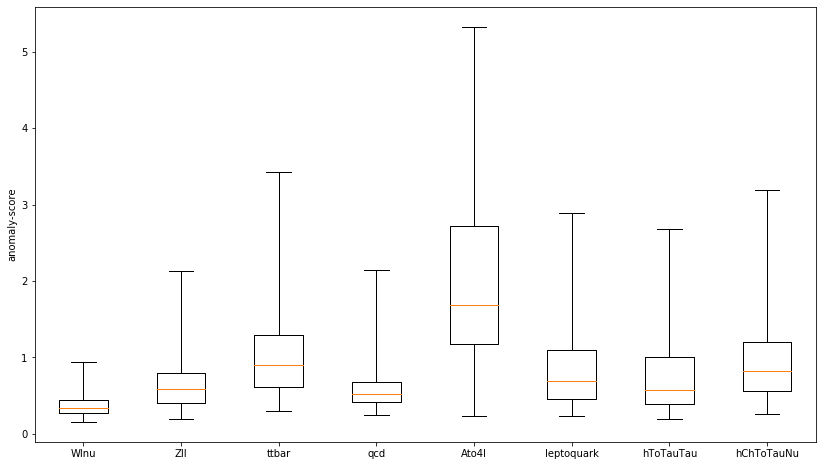

In [13]:
sm_list = ['Wlnu', 'Zll', 'ttbar', 'qcd', 'Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']
score_type = 'l2'
max_samples = 200_000

scores = []
fig, ax = plt.subplots(figsize=(14, 8))
for sm in sm_list:
    x, _ = load_data(data_path, set='valid', type='custom', shuffle=True, sm_list=[sm], bsm_list=[], balance_sm=False)
    x = x[:max_samples]
    x = preprocessor.transform(x)
    score = ad.get_anomaly_scores(x, type=score_type)
    scores.append(score)
    
ax.boxplot(scores, labels=sm_list, whis=[1, 99], showfliers=False)
ax.set_ylabel('anomaly-score')
plt.show()

loading data
data shape:(2033731, 23)
taking subset
data shape:(500000, 23)
running data preprocessor


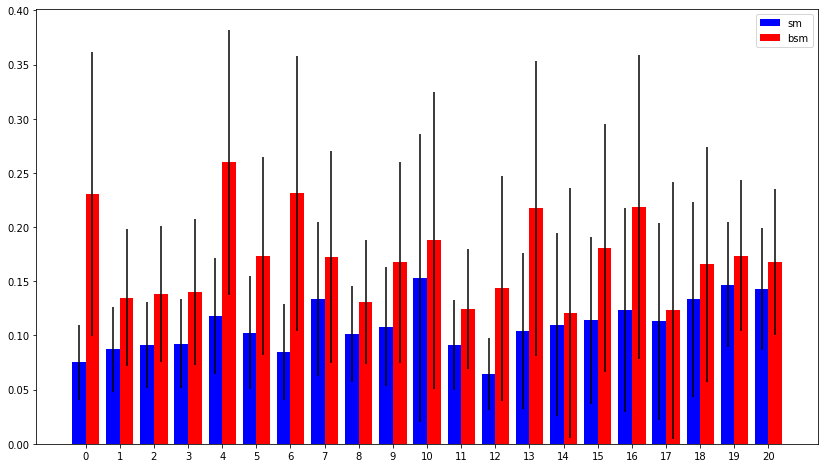

0 = HT
1 = METp
2 = METo
3 = MT
4 = nJets
5 = bJets
6 = allJetMass
7 = LepPt
8 = LepIsoCh
9 = LepIsoGamma
10 = LepIsoNeu
11 = LepCharge
12 = LepIsEle
13 = nMu
14 = allMuMass
15 = allMuPt
16 = nEle
17 = allEleMass
18 = allElePt
19 = nChHad
20 = nNeuHad


In [14]:
max_samples = 500_000
std_scaling = 0.5

sm_list = ['Wlnu', 'Zll', 'ttbar', 'qcd']
bsm_list = ['Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']

sm_list = ['Zll']
bsm_list = ['ttbar']

# loading data
print('loading data')
x, y = load_data(data_path, set='valid', type='custom', shuffle=True, sm_list=sm_list, 
                 bsm_list=bsm_list, balance_sm=False)
print('data shape:' + str(x.shape))
# take subset
if x.shape[0] > max_samples:
    print('taking subset')
    x, y = x[:max_samples], y[:max_samples]
print('data shape:' + str(x.shape))
print('running data preprocessor')
x = preprocessor.transform(x)

# plotting
x_sm = x[y==0]
x_bsm = x[y==1]

x_sm_diff = np.absolute(x_sm - ad.recon(x_sm))
x_bsm_diff = np.absolute(x_bsm - ad.recon(x_bsm))

x_sm_loss = np.mean(x_sm_diff, axis=0)
x_bsm_loss = np.mean(x_bsm_diff, axis=0)
x_sm_std = np.std(x_sm_diff, axis=0)
x_bsm_std = np.std(x_bsm_diff, axis=0)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(x_sm_loss))  # the label locations
width = 0.4  # the width of the bars

ax.bar(x-width/2, x_sm_loss, width = width, yerr=std_scaling*x_sm_std, color='b', label='sm')
ax.bar(x+width/2, x_bsm_loss, width = width, yerr=std_scaling*x_bsm_std, color='r', label='bsm')
ax.legend()
ax.set_xticks(x)

plt.show()

for i, name in enumerate(preprocessor.get_feature_names()):
    print('%s = %s' %(i, name))

loading data
data shape:(5935040, 23)
taking subset
data shape:(500000, 23)
running data preprocessor


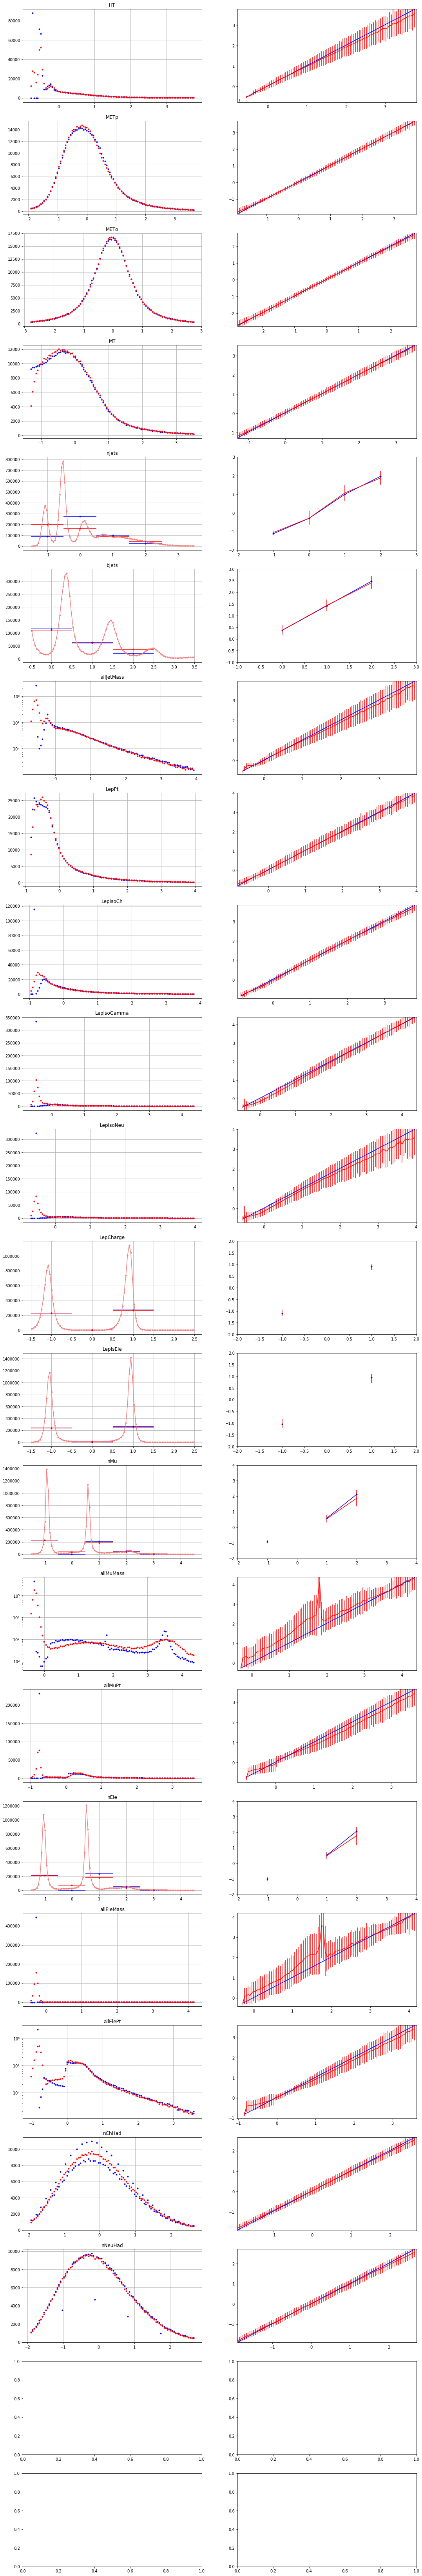

In [15]:
# loading data
print('loading data')
x, y = load_data(data_path, set='valid', type='mix', shuffle=True)
print('data shape:' + str(x.shape))
# take subset
if x.shape[0] > max_samples:
    print('taking subset')
    x, y = x[:max_samples], y[:max_samples]
print('data shape:' + str(x.shape))
print('running data preprocessor')
x = preprocessor.transform(x)

# plotting
plot_mode ={}
plot_mode.update(dict.fromkeys(['nJets', 'bJets','LepCharge','LepIsEle', 'nMu','nEle'],'discrete'))
plot_mode.update(dict.fromkeys(['LepIso', 'allJetMass','allMuMass', 'allMuPt''allEleMass', 'allElePt'],'log'))

x_recon = ad.recon(x)
f, ax_arr = plt.subplots(len(feature_names),2, figsize=(18,120))
for i, name in enumerate(preprocessor.get_feature_names()):
    x_i = x[:,i]
    x_recon_i = x_recon[:,i]
        
    ax0 = ax_arr[i, 0]
    ax1 = ax_arr[i, 1]

    percentile = 1.
    histo_range = (np.minimum(np.percentile(x_recon_i, percentile),np.percentile(x_i, percentile)), 
                   np.maximum(np.percentile(x_recon_i, 100.-percentile),np.percentile(x_i, 100.-percentile)))
    
    
    ax0.set_title(name)
    ax0.grid()
    
    if name not in plot_mode.keys():
        n_bins = 100
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax0.plot(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax0.plot(bin_edges[:-1], bin_content,'r.')
        
        mean, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=n_bins,range=histo_range)
        mean_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=n_bins,range=histo_range)
        std_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=n_bins,range=histo_range)
        
        ax1.plot(bin_edges[:-1], mean, color='b')
        ax1.errorbar(bin_edges[:-1], mean_recon, yerr=std_recon, color='r')
        ax1.set(xlim=histo_range, ylim=histo_range)
        
    elif plot_mode[name] == 'discrete':
        histo_range = (math.floor(histo_range[0]), math.ceil(histo_range[1]))
        
        bins_con = np.linspace(histo_range[0], histo_range[1], 100) + 0.5
        bins_dis = np.arange(histo_range[0], histo_range[1]) + 0.5
        n_bins_dis = len(bins_dis)
        
        # plot recon with 100 bins
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_con)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax0.plot(bincenters, 100./n_bins_dis *bin_content, color='lightcoral', marker='.')
        
        # plot recon and original discrete
        bin_content, bin_edges = np.histogram(x_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax0.errorbar(bincenters, bin_content, xerr = 0.5, fmt='b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax0.errorbar(bincenters, bin_content, xerr = 0.5, fmt='r.')
        
        mean, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=bins_dis)
        mean_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=bins_dis)
        std_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        
        ax1.plot(bincenters, mean,'.-b')
        ax1.errorbar(bincenters, mean_recon, yerr=std_recon, color='r')
        ax1.set(xlim=histo_range, ylim=histo_range)
        
    elif plot_mode[name] == 'log':
        n_bins = 100
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax0.semilogy(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax0.semilogy(bin_edges[:-1], bin_content,'r.')
        
        mean, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=n_bins,range=histo_range)
        mean_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=n_bins,range=histo_range)
        std_recon, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=n_bins,range=histo_range)
        
        ax1.plot(bin_edges[:-1], mean, color='b')
        ax1.errorbar(bin_edges[:-1], mean_recon, yerr=std_recon, color='r')
        ax1.set(xlim=histo_range, ylim=histo_range)
        
    else: raise Exception()
    
plt.show()

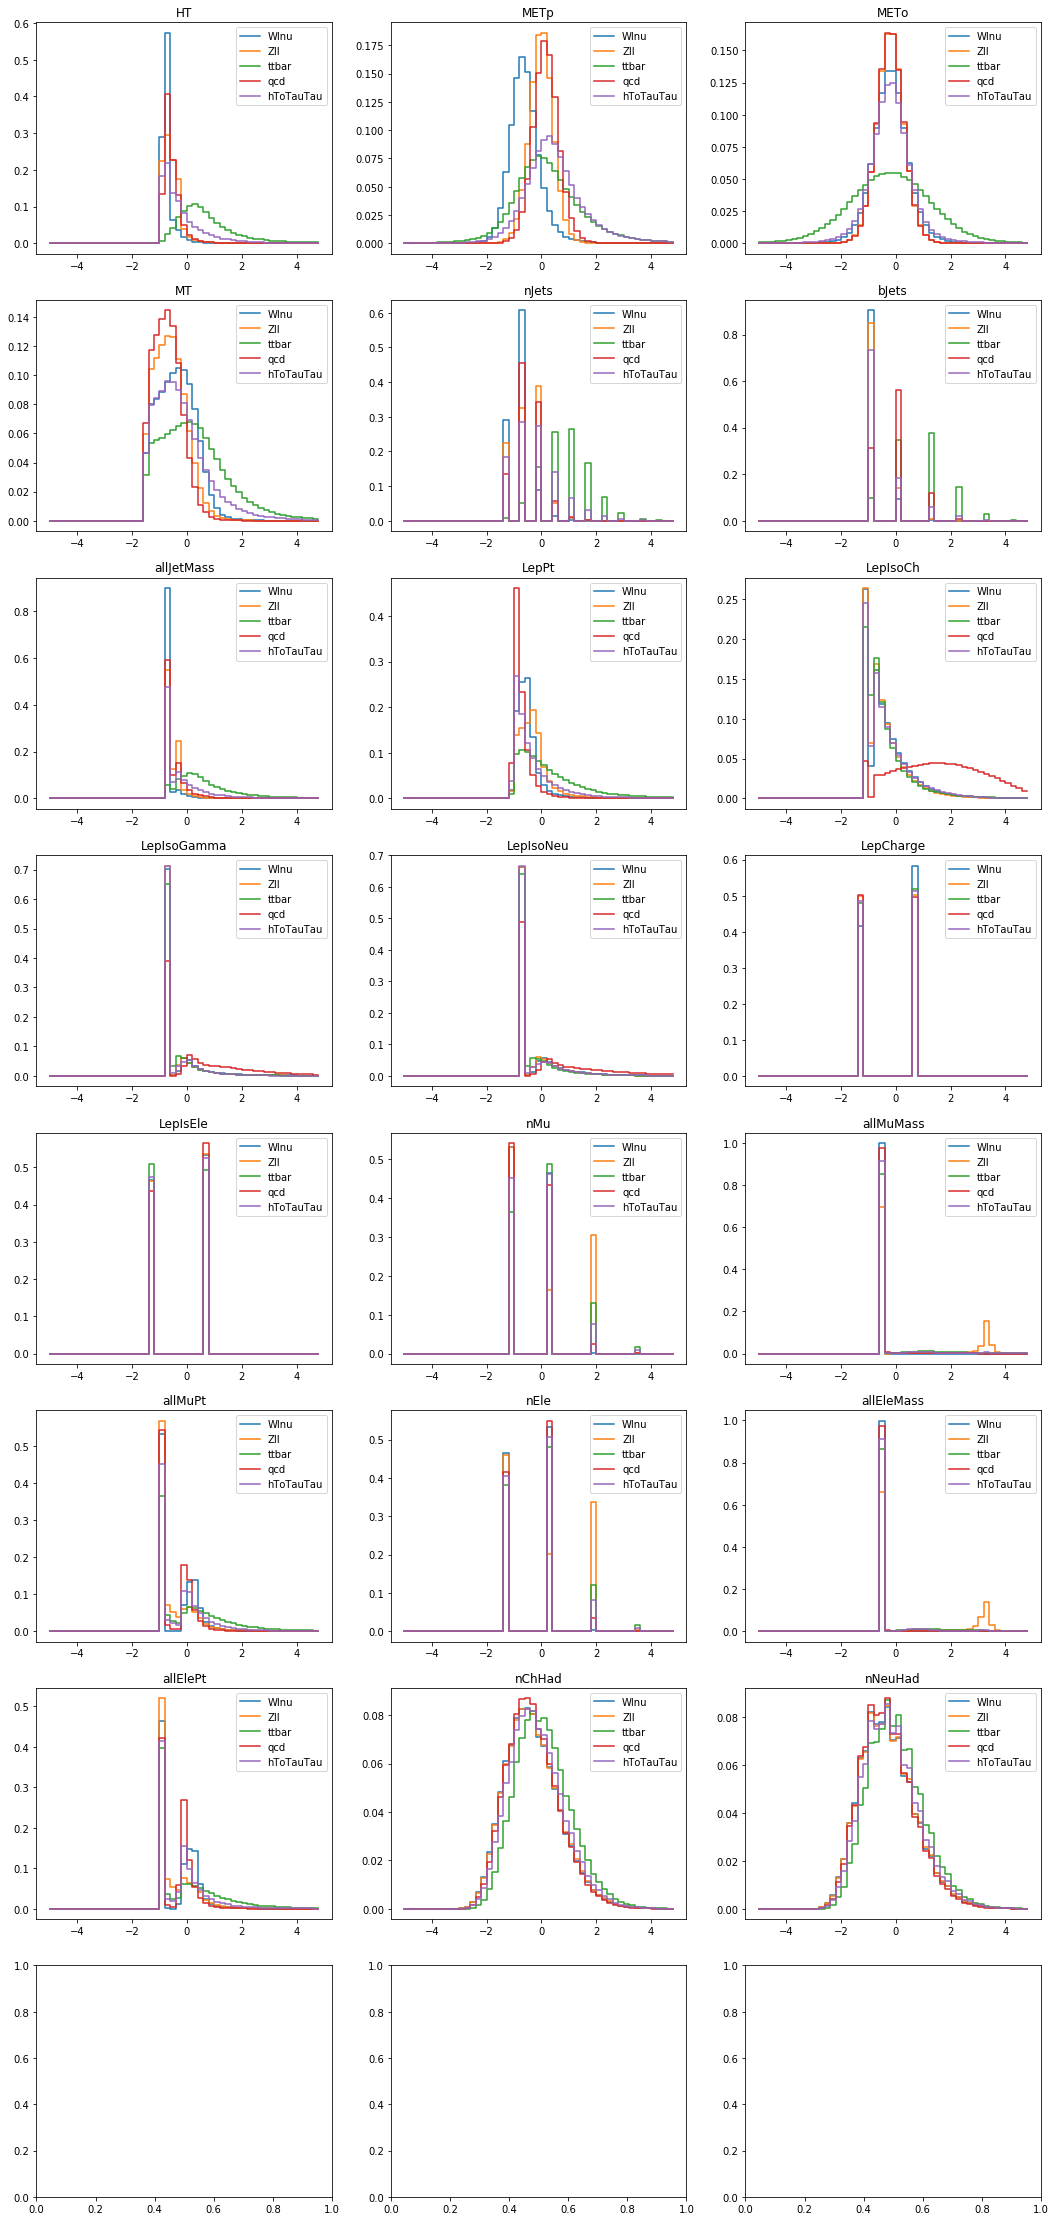

In [16]:
sm_list = ['Wlnu', 'Zll', 'ttbar', 'qcd', 'hToTauTau']
bsm_list = ['Ato4l', 'leptoquark', 'hToTauTau', 'hChToTauNu']

f, ax_arr = plt.subplots(int(len(feature_names)/3)+1,3, figsize=(18,40))

for sm in sm_list:
    x, _ = load_data(data_path, set='valid', type='custom', shuffle=True, sm_list=[sm], bsm_list=[], balance_sm=False)
    x = preprocessor.transform(x)
    
    for i, name in enumerate(preprocessor.get_feature_names()):
        ax = ax_arr[int(i / 3), i % 3]
        bin_content, bin_edges = np.histogram(x[:,i], bins=50, range=[-5, 5])
        bin_content = bin_content / x.shape[0]
        ax.step(bin_edges[:-1], bin_content, label=sm)
        #ax.plot(bin_edges[:-1], bin_content, '.', label=sm)
        ax.set_title(name)
        ax.legend()
        
plt.show()